In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
from audiocraft.models import MusicGen
from audiocraft.models import LMModel
from audiocraft.modules.conditioners import WavCondition, ChromaChordConditioner
from audiocraft.modules.chord_chroma import ChordExtractor

In [7]:
import torch, torchaudio
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [8]:
loaded = torch.load("/home/sake/audiocraft/state_dict_MusicGen_Melody.bin")

In [9]:
model = MusicGen.get_pretrained('facebook/musicgen-melody')

In [10]:
model.lm

LMModel(
  (cfg_dropout): ClassifierFreeGuidanceDropout(p=0.2)
  (att_dropout): AttributeDropout({'args': defaultdict(<function AttributeDropout.__init__.<locals>.<lambda> at 0x7f856c370ee0>, {'active_on_eval': False}), 'text': defaultdict(<function AttributeDropout.__init__.<locals>.<lambda> at 0x7f84d6661ee0>, {}), 'wav': defaultdict(<function AttributeDropout.__init__.<locals>.<lambda> at 0x7f84d66618b0>, {'self_wav': 0.5})})
  (condition_provider): ConditioningProvider(
    (conditioners): ModuleDict(
      (self_wav): ChromaStemConditioner(
        (output_proj): Linear(in_features=12, out_features=1536, bias=True)
        (chroma): ChromaExtractor(
          (spec): Spectrogram()
        )
      )
      (description): T5Conditioner(
        (output_proj): Linear(in_features=768, out_features=1536, bias=True)
      )
    )
  )
  (fuser): ConditionFuser()
  (emb): ModuleList(
    (0-3): 4 x ScaledEmbedding(2049, 1536)
  )
  (transformer): StreamingTransformer(
    (layers): ModuleL

In [16]:
model.lm.condition_provider.conditioners.self_wav.chroma.

AttributeError: 'ChromaExtractor' object has no attribute 'attribute'

In [24]:
model.lm.condition_provider.conditioners.self_wav.chroma = ChordExtractor('cuda', 32000, 30, 235, 12)

In [6]:
wav = torchaudio.load('/mnt/nvme/MSD_INST_vocalless/mdx_extra/1/0/1021.clip.wav')

In [7]:
wav[0].shape

torch.Size([2, 961307])

In [8]:
sr = wav[1]
sr

32000

In [9]:
audio = wav[0][:,654:961307-653]
audio.shape

torch.Size([2, 960000])

In [10]:
wavcon = WavCondition(audio[None].to('cuda'), torch.tensor([audio.shape[-1]]), sample_rate=[sr], path=[None],)

In [11]:
wavcon

WavCondition(wav=tensor([[[ 1.4954e-03,  7.6294e-04, -5.4932e-04,  ..., -2.7466e-04,
          -4.2725e-04, -6.1035e-05],
         [ 1.2207e-03, -4.8828e-04, -2.4719e-03,  ..., -1.8311e-04,
          -3.9673e-04,  6.1035e-05]]], device='cuda:0'), length=tensor([960000]), sample_rate=[32000], path=[None], seek_time=[])

In [12]:
model.lm.condition_provider

ConditioningProvider(
  (conditioners): ModuleDict(
    (self_wav): ChromaStemConditioner(
      (output_proj): Linear(in_features=12, out_features=1536, bias=True)
      (chroma): ChromaExtractor(
        (spec): Spectrogram()
      )
    )
    (description): T5Conditioner(
      (output_proj): Linear(in_features=768, out_features=1536, bias=True)
    )
  )
)

In [13]:
import demucs

In [14]:
model.lm.condition_provider.conditioners.self_wav.demucs.sources.index('bass')

1

In [15]:
model.lm.condition_provider.conditioners.self_wav.demucs.sources.index('other')

2

In [16]:
model.lm.condition_provider.conditioners.self_wav.stem_indices = torch.LongTensor([model.lm.condition_provider.conditioners.self_wav.demucs.sources.index('bass'), model.lm.condition_provider.conditioners.self_wav.demucs.sources.index('other')]).to('cuda')

In [17]:
melody_chroma = model.lm.condition_provider.conditioners.self_wav._compute_wav_embedding(wavcon.wav, wavcon.sample_rate[0])

In [18]:
stemmed_wav = model.lm.condition_provider.conditioners.self_wav._get_stemmed_wav(wavcon.wav, wavcon.sample_rate[0])

In [19]:
spec = model.lm.condition_provider.conditioners.self_wav.chroma.spec(stemmed_wav.mean(1, keepdim=True)).squeeze(1)
spec.shape

torch.Size([1, 8193, 235])

In [20]:
raw_chroma = torch.einsum('cf,...ft->...ct', model.lm.condition_provider.conditioners.self_wav.chroma.fbanks, spec)
raw_chroma.shape

torch.Size([1, 12, 235])

In [21]:
norm_chroma = torch.nn.functional.normalize(raw_chroma, p=model.lm.condition_provider.conditioners.self_wav.chroma.norm, dim=-2, eps=1e-6)
norm_chroma.shape

torch.Size([1, 12, 235])

In [22]:
model.lm.condition_provider.conditioners.self_wav.chroma.fbanks.shape

torch.Size([12, 8193])

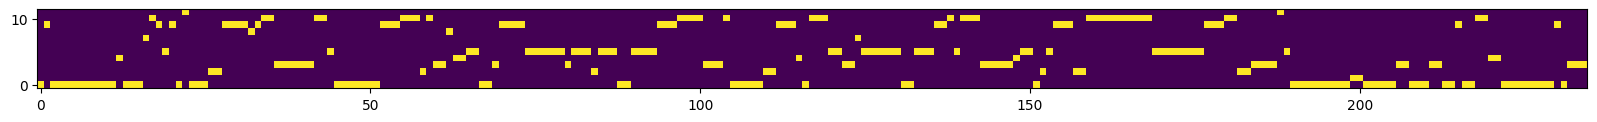

In [23]:
plt.figure(figsize = (20,2))
plt.imshow(melody_chroma.squeeze(0).T.cpu().numpy(), origin='lower', interpolation='nearest')

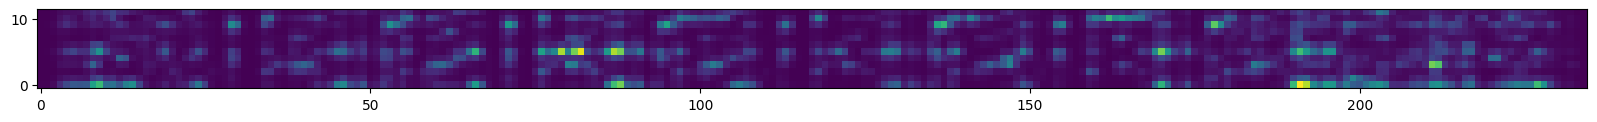

In [24]:
plt.figure(figsize = (20,2))
plt.imshow(raw_chroma.squeeze(0).cpu().numpy(), origin='lower', interpolation='nearest')

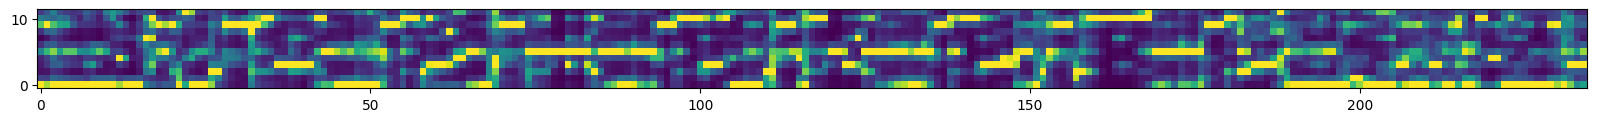

In [68]:
plt.figure(figsize = (20,2))
plt.imshow(norm_chroma.squeeze(0).cpu().numpy(), origin='lower', interpolation='nearest')

In [170]:
model.lm.condition_provider.conditioners.self_wav.duration

[autoreload of audiocraft.modules.conditioners failed: Traceback (most recent call last):
  File "/home/sake/.local/share/virtualenvs/audiocraft-yxa8GELE/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/home/sake/.local/share/virtualenvs/audiocraft-yxa8GELE/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
  File "/usr/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 844, in exec_module
  File "<frozen importlib._bootstrap_external>", line 981, in get_code
  File "<frozen importlib._bootstrap_external>", line 911, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/sake/audiocraft/audiocraft/modules/conditioners.py", line 7

30

------

# Chord Recog

In [27]:
from audiocraft.modules.btc.btc_model import *
from audiocraft.modules.btc.utils.mir_eval_modules import audio_file_to_features, idx2chord, idx2voca_chord, get_audio_paths
from audiocraft.modules.btc.utils import chords
import os
import librosa

In [28]:
config = HParams.load("audiocraft/modules/btc/run_config.yaml")

In [29]:
device = 'cuda'

In [30]:
config.feature['large_voca'] = True
config.model['num_chords'] = 170
model_file = 'audiocraft/modules/btc/test/btc_model_large_voca.pt'
idx_to_chord = idx2voca_chord()

In [31]:
btcmodel = BTC_model(config=config.model).to(device)

In [32]:
if os.path.isfile(model_file):
    checkpoint = torch.load(model_file)
    mean = checkpoint['mean']
    std = checkpoint['std']
    btcmodel.load_state_dict(checkpoint['model'])
    logger.info("restore model")

In [33]:
original_wav = librosa.resample(stemmed_wav.cpu().numpy(), orig_sr=sr, target_sr=config.mp3['song_hz'])

In [34]:
original_wav = original_wav.squeeze(0).squeeze(0)
original_wav.shape

(661500,)

In [35]:
sr = config.mp3['song_hz']

In [151]:
currunt_sec_hz = 0
while len(original_wav) > currunt_sec_hz + config.mp3['song_hz'] * config.mp3['inst_len']:
    start_idx = int(currunt_sec_hz)
    end_idx = int(currunt_sec_hz + config.mp3['song_hz'] * config.mp3['inst_len'])
    tmp = librosa.cqt(original_wav[start_idx:end_idx], sr=sr, n_bins=config.feature['n_bins'], bins_per_octave=config.feature['bins_per_octave'], hop_length=config.feature['hop_length'])
    if start_idx == 0:
        feature = tmp
    else:
        feature = np.concatenate((feature, tmp), axis=1)
    currunt_sec_hz = end_idx
tmp = librosa.cqt(original_wav[currunt_sec_hz:], sr=sr, n_bins=config.feature['n_bins'], bins_per_octave=config.feature['bins_per_octave'], hop_length=config.feature['hop_length'])
feature = np.concatenate((feature, tmp), axis=1)
feature = np.log(np.abs(feature) + 1e-6)
feature_per_second = config.mp3['inst_len'] / config.model['timestep']
song_length_second = len(original_wav)/config.mp3['song_hz']

In [152]:
feature.shape

(144, 324)

In [153]:
feature = feature.T

In [154]:
feature.shape

(324, 144)

In [155]:
feature = (feature - mean)/std

In [157]:
time_unit = feature_per_second
n_timestep = config.model['timestep']
time_unit, n_timestep

(0.09259259259259259, 108)

In [158]:
num_pad = n_timestep - (feature.shape[0] % n_timestep)
feature = np.pad(feature, ((0, num_pad), (0, 0)), mode="constant", constant_values=0)
num_instance = feature.shape[0] // n_timestep
num_pad, feature.shape, num_instance

(108, (432, 144), 4)

In [159]:
type(feature)

numpy.ndarray

In [160]:
#Single Batch

start_time = 0.0
lines = []
with torch.no_grad():
    btcmodel.eval()
    feature = torch.tensor(feature, dtype=torch.float32).unsqueeze(0).to(device)
    for t in range(num_instance):
        self_attn_output, _ = btcmodel.self_attn_layers(feature[:, n_timestep * t:n_timestep * (t + 1), :])
        prediction, _ = btcmodel.output_layer(self_attn_output)
        prediction = prediction.squeeze()
        for i in range(n_timestep):
            if t == 0 and i == 0:
                prev_chord = prediction[i].item()
                continue
            if prediction[i].item() != prev_chord:
                lines.append(
                    '%.3f %.3f %s\n' % (start_time, time_unit * (n_timestep * t + i), idx_to_chord[prev_chord]))
                start_time = time_unit * (n_timestep * t + i)
                prev_chord = prediction[i].item()
            if t == num_instance - 1 and i + num_pad == n_timestep:
                if start_time != time_unit * (n_timestep * t + i):
                    lines.append('%.3f %.3f %s\n' % (start_time, time_unit * (n_timestep * t + i), idx_to_chord[prev_chord]))
                break

In [161]:
lines

['0.000 1.852 F\n',
 '1.852 2.500 F:7\n',
 '2.500 3.611 F\n',
 '3.611 4.167 F:7\n',
 '4.167 4.537 A#\n',
 '4.537 5.185 D#\n',
 '5.185 5.556 A#\n',
 '5.556 6.852 F\n',
 '6.852 7.407 A#\n',
 '7.407 8.056 D#\n',
 '8.056 9.444 F\n',
 '9.444 10.000 A#\n',
 '10.000 10.648 D#\n',
 '10.648 10.926 A#\n',
 '10.926 12.222 F\n',
 '12.222 12.778 A#\n',
 '12.778 13.333 D#\n',
 '13.333 13.611 C\n',
 '13.611 14.907 F\n',
 '14.907 15.556 A#\n',
 '15.556 15.833 D#\n',
 '15.833 16.296 A#\n',
 '16.296 17.500 F\n',
 '17.500 18.148 A#\n',
 '18.148 18.704 D#\n',
 '18.704 18.796 E\n',
 '18.796 20.000 F\n',
 '20.000 20.278 N\n',
 '20.278 20.463 A#\n',
 '20.463 21.296 G:min\n',
 '21.296 21.667 A#\n',
 '21.667 22.870 F\n',
 '22.870 23.611 A#\n',
 '23.611 24.074 D#\n',
 '24.074 24.167 F\n',
 '24.167 30.000 F:7\n']

In [43]:
lines

['0.000 1.852 F\n',
 '1.852 2.500 F:7\n',
 '2.500 3.611 F\n',
 '3.611 4.167 F:7\n',
 '4.167 4.537 A#\n',
 '4.537 5.185 D#\n',
 '5.185 5.556 A#\n',
 '5.556 6.852 F\n',
 '6.852 7.407 A#\n',
 '7.407 8.056 D#\n',
 '8.056 9.444 F\n',
 '9.444 10.000 A#\n',
 '10.000 10.648 D#\n',
 '10.648 10.926 A#\n',
 '10.926 12.222 F\n',
 '12.222 12.778 A#\n',
 '12.778 13.333 D#\n',
 '13.333 13.611 C\n',
 '13.611 14.907 F\n',
 '14.907 15.556 A#\n',
 '15.556 15.833 D#\n',
 '15.833 16.296 A#\n',
 '16.296 17.500 F\n',
 '17.500 18.148 A#\n',
 '18.148 18.704 D#\n',
 '18.704 18.796 E\n',
 '18.796 20.000 F\n',
 '20.000 20.278 N\n',
 '20.278 20.463 A#\n',
 '20.463 21.296 G:min\n',
 '21.296 21.667 A#\n',
 '21.667 22.870 F\n',
 '22.870 23.611 A#\n',
 '23.611 24.074 D#\n',
 '24.074 24.167 F\n',
 '24.167 30.000 F:7\n']

In [162]:
strlines = ''.join(lines)

In [163]:
chords = chords.Chords()

AttributeError: 'Chords' object has no attribute 'Chords'

In [164]:
crds = chords.chords('EbC')
crds

array([(4, 0, [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],  True),
       (5, 0, [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],  True),
       (0, 0, [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],  True)],
      dtype=[('root', '<i8'), ('bass', '<i8'), ('intervals', '<i8', (12,)), ('is_major', '?')])

In [166]:
chroma = torch.zeros([235,12])

In [167]:
timebin = 30/235

In [168]:
for line in lines:
    splits = line.split()
    if len(splits) == 3:
        s = splits[0]
        e = splits[1]
        l = splits[2]

    crd = chords.chord(l)
    
    if crd[0] == -1:
        multihot = torch.Tensor(crd[2])
    else:
        multihot = torch.concat([torch.Tensor(crd[2])[-crd[0]:],torch.Tensor(crd[2])[:-crd[0]]])
    start_bin = round(float(s)/timebin)
    end_bin = round(float(e)/timebin)
    for j in range(start_bin,end_bin):
        chroma[j]=multihot

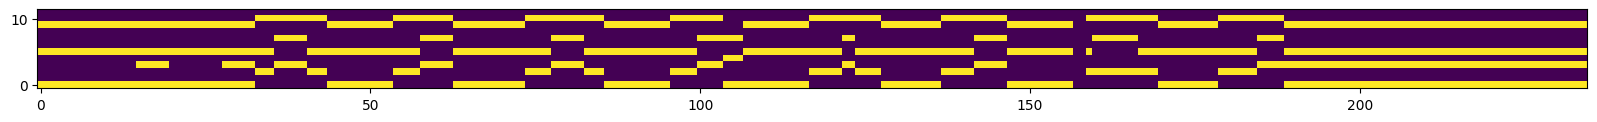

In [169]:
plt.figure(figsize = (20,2))
plt.imshow(chroma.T, origin='lower', interpolation='nearest')